In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.fft as sci

In [2]:
# Setting up
A = np.loadtxt('BBChaos145Hz-1-2.txt') # load data
#d = A[0:2**14, 0] # driving
y = A[0:2**14, 1] # bouncing ball

decimate = 2**2 # number of points to sample

y = signal.decimate(y, decimate) # truncate to 2ˆ14/4

N = np.size(y) # no of data points
n = np.linspace(0,N,N) # data point array

f_s = 44100 # sampling freq
f_s = f_s / decimate # new sampling freq
dt = 1/ f_s # new sampling interval
f = n*f_s /N # set frequency axis

P_b = np.abs(sci.fft(y))**2 # power spectrum of y
F_y = sci.fft(y) # fft of y


# Wavelet Transform
t = np.linspace(1,N,N)
t0 = N/2 # location of the wavelet
x = np.arange(0.5, 2.6, 0.1)
scale = 10**x # array of logarithmically spaced scales

scalesize = np.size(scale)

# Mexican Hat
T_mex = (dt*2*np.pi*scale)/np.sqrt(2.5) # array of Fourier wavelenths for Mexican Hat
f_mex = 1/ T_mex # array of frequencies

# Morlet
omega0 = 6.0
T_mor = dt*4.0*np.pi*scale/(omega0 + np.sqrt(2+omega0**2))  # array of Fourier wavelengths for Morlet
f_mor = 1/ T_mor    # array of frequencies

In [3]:
# Generate normally distributed white noise with same SD as data
sigma = np.std(y) #SD of y
# mu = np.mean(y) # mean of y

ran = sigma*np.random.randn(N) # random noise array of length y
F_ran = sci.fft(ran) #FFT of random noise

# Initialise wavelet transform matricies
WT_mex = np.zeros((scalesize ,N)) # mexican hat
WT_mor = np.zeros((scalesize ,N),dtype=complex) # morelet
WTnoi_mex = np.zeros((scalesize ,N)) # mexican hat white noise
WTnoi_mor = np.zeros((scalesize ,N),dtype=complex) # morlet white noise

# Calculating the wavelet transforms
for ii in range(0,scalesize):

    s = scale[ii]
    
    # Mexican hat
    w_mex = ( 1 - ( (t-t0)/s )**2 )*np.exp( -0.5*( (t-t0)/s )**2 )
    w_mex = w_mex*(2/np.sqrt(3))*(1/np.sqrt(np.sqrt(np.pi)))
    w_mex = np.concatenate(( w_mex[N//2:N], w_mex [0:N//2]))                # center and reverse
    F_mex = np.real( np.sqrt( 2*np.pi*s*f_s )*sci.fft(w_mex ))              #FFT of mexican hat function
    WT_mex[ii,:] = np.abs(sci.ifft(np.conjugate(F_mex.T)*F_y ))             #WT of mexican hat with data
    WTnoi_mex[ii,:] = np.abs(sci.ifft(np.conjugate(F_mex)*F_ran ))          #WT of mexican hat with noise
    
    # Morlet
    w_mor = np.exp(1j*omega0*((t-t0)/s))
    w_mor = w_mor*np.exp(-0.5*((t-t0)/s)**2)
    w_mor = w_mor /(np.pi**(0.25))
    w_mor = np.concatenate(( w_mor[int(N/2):N],w_mor [0:int(N/2)]))         # center & reverse
    F_mor = np.sqrt(2*np.pi*s*f_s)*sci.fft(w_mor)                           #FFT of morlet function
    WT_mor[ii,:] = sci.ifft(np.conjugate(F_mor.T)*F_y )                     #WT of morlet with data
    WTnoi_mor[ii,:] = sci.ifft(np.conjugate(F_mor)*F_ran)                   #WT of morlet with noise

# PSD of data & noise
white_noise_power_spectrum = np.abs(sci.fft(ran/sigma))**2
original_data_power_spectrum = np.abs(sci.fft(y))**2
white_noise_power_spectrum_scaled = np.abs(sci.fft(ran))**2

# only values of |WT| > |WT_noise|, find significance via the ratio of these two
def filter(WT,WTnoise,alpha):
    np.random.seed(6)   # for reproduceable results of randomisations
    WT_filter = WT
    for ii in range(0,scalesize):
        for jj in range(0,N-1):
            if np.abs(WT[ii,jj]) < alpha*np.abs(WTnoise[ii,jj]):
                WT_filter[ii,jj] = 0    
    return WT_filter


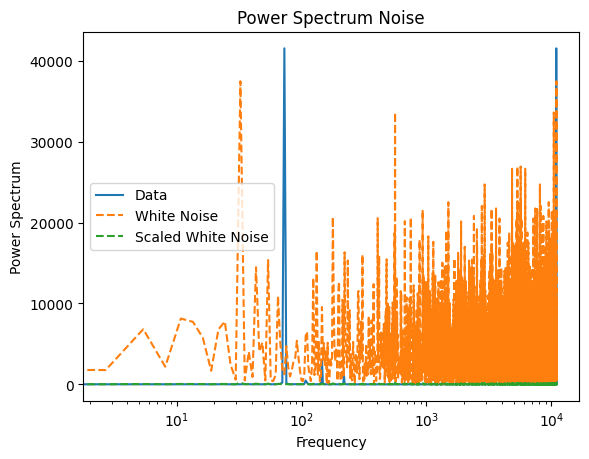

In [4]:
# plot the power spectrum of the noise
# what does this show? Have subplot in loglog space to show the data is the same as before
# perhaps have a plot where the random noise is not scaled accordingly and its effects. 

# FFT noise & data
plt.figure(1)
plt.plot(f, original_data_power_spectrum , label='Data')
plt.semilogx(f, white_noise_power_spectrum , linestyle = '--', label='White Noise')
plt.plot(f, white_noise_power_spectrum_scaled , linestyle = '--', label='Scaled White Noise')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.legend()
#plt.ylim([0,0.8e6])
plt.title('Power Spectrum Noise')
plt.show()



Text(0.5, 1.0, 'Morlet')

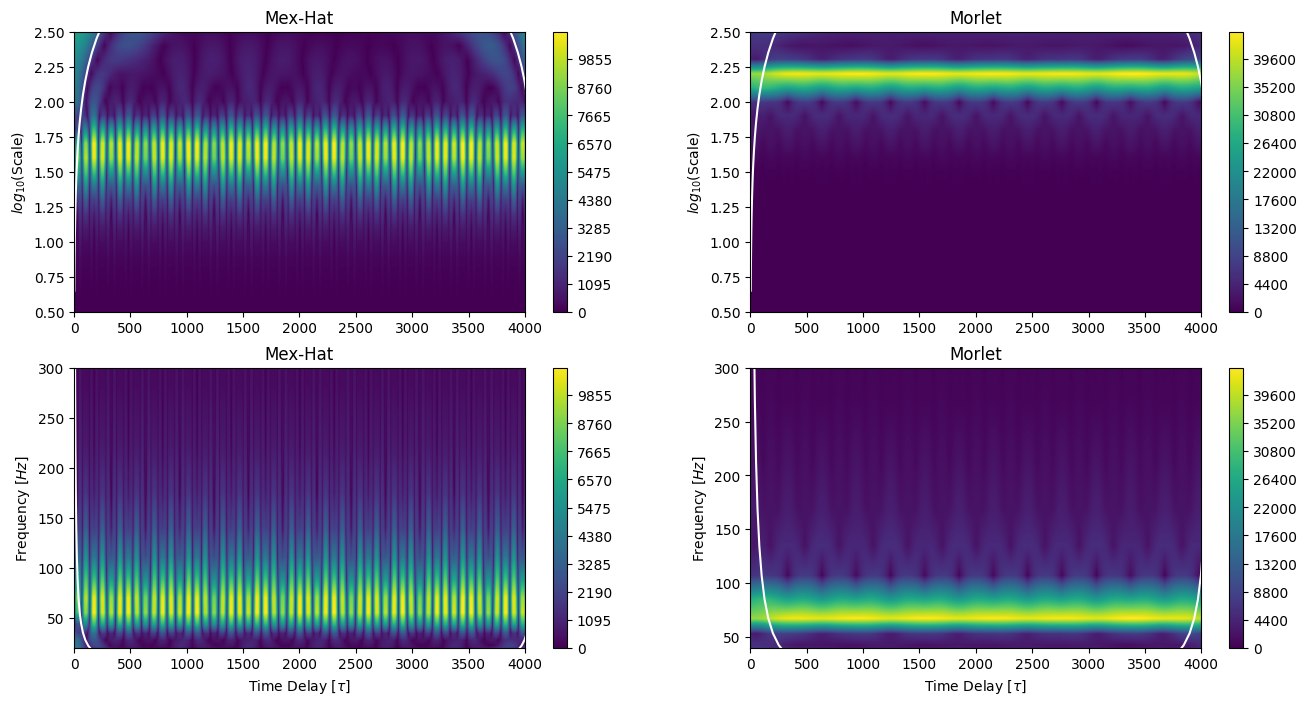

In [5]:
# Plot the functions unfiltered from noise, regards to time elay & scales (linear)
fig = plt.figure(2, figsize=(16,8))
coi = np.sqrt(2.0)*scale

# Mex-hat
ax = fig.add_subplot(221)
CB = ax.contourf(t,x,np.abs(WT_mex), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,np.log10(coi),'w-')
plt.plot(np.max(t)-scale ,np.log10(coi),'w-')
plt.ylim([0.5,2.5])
plt.xlim([0,4000])
plt.ylabel('$log_{10}$(Scale)')
plt.title('Mex-Hat')

# Morlet
ax = fig.add_subplot(222)
CB = ax.contourf(t,x,np.abs(WT_mor), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,np.log10(coi),'w-')
plt.plot(np.max(t)-scale ,np.log10(coi),'w-')
plt.ylim([0.5,2.5])
plt.xlim([0,4000])
plt.ylabel('$log_{10}$(Scale)')
plt.title('Morlet')

# Plot the functions unfiltered from noise, regards to time delay & wavelet frequencies

# Mex-hat
ax = fig.add_subplot(223)
CB = ax.contourf(t,f_mex,np.abs(WT_mex), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,f_mex,'w-')
plt.plot(np.max(t)-scale ,f_mex,'w-')
plt.ylim([20,300])
plt.xlim([0,4000])
plt.ylabel('Frequency $[Hz]$')
plt.xlabel('Time Delay [$\\tau$]')
plt.title('Mex-Hat')

# Morlet
ax = fig.add_subplot(224)
CB = ax.contourf(t,f_mor,np.abs(WT_mor), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale, f_mor,'w-')
plt.plot(np.max(t)-scale ,f_mor,'w-')
plt.ylim([40,300])
plt.xlim([0,4000])
plt.xlabel('Time Delay [$\\tau$]')
plt.ylabel('Frequency $[Hz]$')
plt.title('Morlet')

Text(0.5, 1.0, 'Morlet of White Noise')

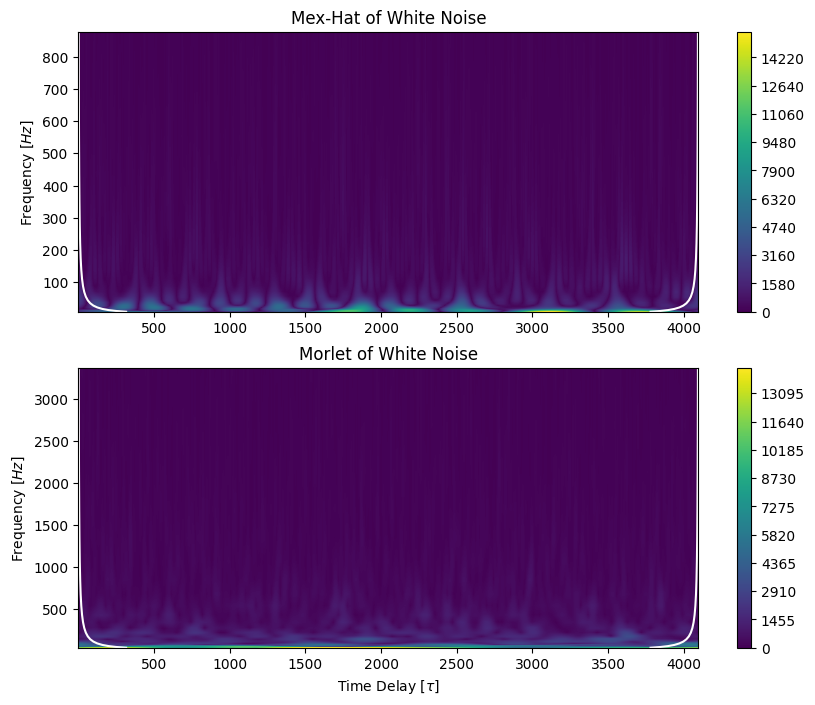

In [6]:
# Plot the noise functions, regards to time delay & wavelet frequencies
fig = plt.figure(3, figsize=(10,8))
coi = np.sqrt(2.0)*scale

# Mex-hat
ax = fig.add_subplot(211)
CB = ax.contourf(t,f_mex,np.abs(WTnoi_mex), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,f_mex,'w-')
plt.plot(np.max(t)-scale ,f_mex,'w-')
#plt.ylim([20,300])
#plt.xlim([0,4000])
plt.ylabel('Frequency $[Hz]$')
plt.title('Mex-Hat of White Noise')

# Morlet
ax = fig.add_subplot(212)
CB = ax.contourf(t,f_mor,np.abs(WTnoi_mor), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale, f_mor,'w-')
plt.plot(np.max(t)-scale ,f_mor,'w-')
#plt.ylim([40,300])
#plt.xlim([0,4000])
plt.xlabel('Time Delay [$\\tau$]')
plt.ylabel('Frequency $[Hz]$')
plt.title('Morlet of White Noise')

Text(0, 0.5, 'Frequency [$Hz$]')

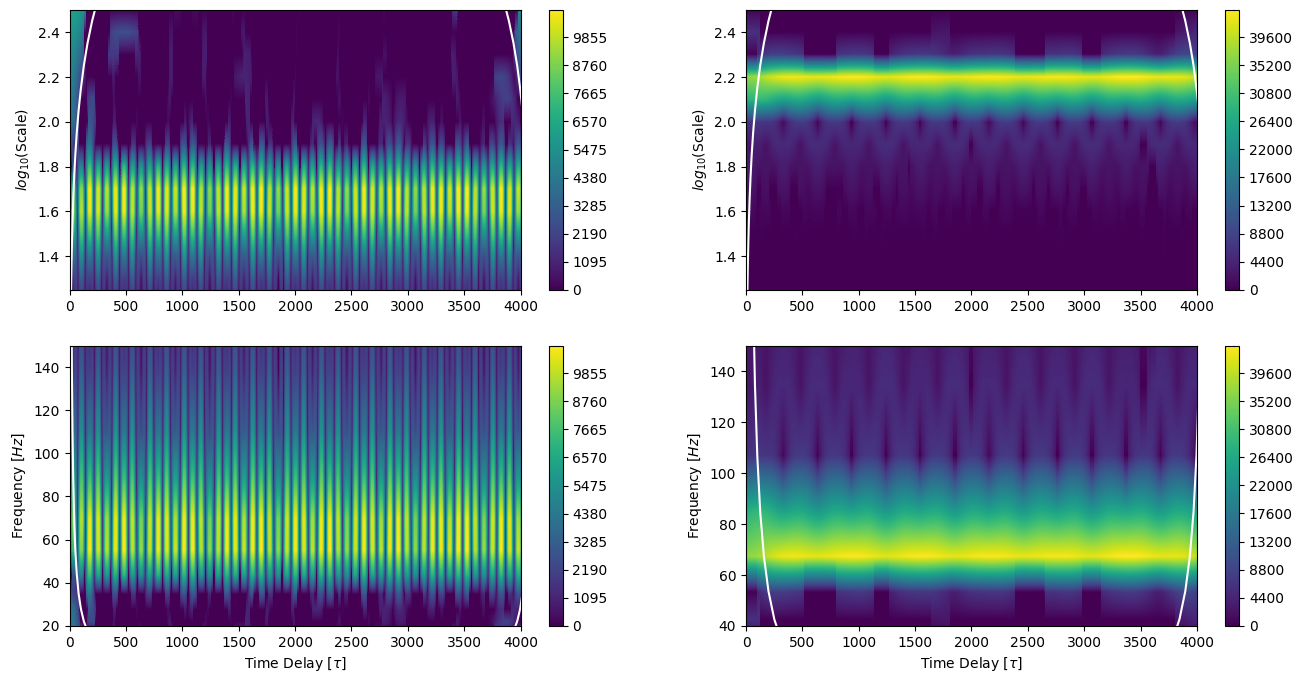

In [7]:
# Plot functions filtered from noise, regards to time delay and scale

alpha = 1   # to change the strength of standard deviation
WT_filtered_mex = filter(WT_mex,WTnoi_mex,alpha)
WT_filtered_mor = filter(WT_mor,WTnoi_mor,alpha)

fig = plt.figure(6, figsize=(16,8))
coi = np.sqrt(2.0)*scale

# Mex-hat
ax = fig.add_subplot(221)
CB = ax.contourf(t,x,np.abs(WT_filtered_mex), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,np.log10(coi),'w-')
plt.plot(np.max(t)-scale ,np.log10(coi),'w-')
plt.ylim([1.25,2.5])
plt.xlim([0,4000])
plt.ylabel('$log_{10}$(Scale)')
#plt.title('Mex-Hat, Filtered')

# Morlet
ax = fig.add_subplot(222)
CB = ax.contourf(t,x,np.abs(WT_filtered_mor), 1000)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,np.log10(coi),'w-')
plt.plot(np.max(t)-scale ,np.log10(coi),'w-')
plt.ylim([1.25,2.5])
plt.xlim([0,4000])
plt.ylabel('$log_{10}$(Scale)')
#plt.title('Morlet, Filtered')


# Plot the functions filtered from noise, regards to time delay and wavelet frequencies

## Significances, y-axis = frequencies of the wavelets
# Mex-hat
ax = fig.add_subplot(223)
CB = ax.contourf(t,f_mex,np.abs(WT_filtered_mex), 1000)
fig.colorbar(CB,ax=ax)
plt.ylim([20,150])
plt.xlim([0,4000])
plt.plot(scale ,f_mex,'w-')
plt.plot(np.max(t)-scale ,f_mex,'w-')
plt.plot(scale ,np.log10(coi),'w-')
plt.ylabel('Frequency [$Hz$]')
plt.xlabel('Time Delay [$\\tau$]')
#plt.title('$|W| > |W_{noise}|$, Mex-Hat')

# Morlet
ax = fig.add_subplot(224)
CB = ax.contourf(t,f_mor,np.abs(WT_filtered_mor), 1000)
fig.colorbar(CB,ax=ax)
plt.ylim([40,150])
plt.xlim([0,4000])
plt.plot(scale ,f_mor,'w-')
plt.plot(np.max(t)-scale ,f_mor,'w-')
plt.plot(scale ,np.log10(coi),'w-')
plt.xlabel('Time Delay [$\\tau$]')
plt.ylabel('Frequency [$Hz$]')
#plt.title('$|W| > |W_{noise}|$, Morlet')
